## Code Overview:

Compares multiple model architectures like vanilla nets, wide nets, deep nets and ResNets. For efficient loss landscape probing I used hessian eigenvalues, sharpness metrics and 2D visualizations. I also performed a mode connectivity analysis to visualize paths between different minima.

The experiments correlate sharpness with the generalization; architecture comparison to see how design affects landscape geometry; eigenvalue analysis using top-k hessian eigenvalues, eigenvalues are calculated efficiently in O(kn) instead of O(n^3).

In [1]:
"""
Neural Network Loss Landscape Analysis Framework
Efficient implementation for understanding optimization dynamics and generalization
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
from copy import deepcopy
import time

## Neural Network Architecture

In [2]:
class SimpleNet(nn.Module):
    """Basic MLP for testing"""
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, depth=3):
        super().__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        
        for _ in range(depth - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [3]:
class ResidualBlock(nn.Module):
    """Residual block with skip connections"""
    def __init__(self, dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.fc2 = nn.Linear(dim, dim)
    
    def forward(self, x):
        return x + F.relu(self.fc2(F.relu(self.fc1(x))))

In [4]:
class ResNet(nn.Module):
    """ResNet-style architecture"""
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=2, depth=3):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(depth)])
        self.output_layer = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for block in self.blocks:
            x = block(x)
        return self.output_layer(x)

## Loss Landscaping Probing Methods

In [5]:
class LandscapeAnalyzer:
    """Efficient loss landscape analysis toolkit"""
    
    def __init__(self, model, criterion, device='cpu'):
        self.model = model
        self.criterion = criterion
        self.device = device
        self.model.to(device)
    
    def get_params_vector(self):
        """Flatten all parameters into a single vector"""
        return torch.cat([p.data.view(-1) for p in self.model.parameters()])
    
    def set_params_vector(self, vec):
        """Set model parameters from a flattened vector"""
        offset = 0
        for p in self.model.parameters():
            numel = p.numel()
            p.data.copy_(vec[offset:offset+numel].view(p.shape))
            offset += numel
    
    def compute_loss(self, dataloader):
        """Compute average loss over dataset"""
        self.model.eval()
        total_loss = 0
        count = 0
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item() * inputs.size(0)
                count += inputs.size(0)
        return total_loss / count
    
    def compute_accuracy(self, dataloader):
        """Compute classification accuracy"""
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        return 100. * correct / total
    
    def linear_interpolation(self, theta1, theta2, dataloader, steps=25):
        """Compute loss along linear path between two parameter vectors"""
        original_params = self.get_params_vector().clone()
        
        alphas = np.linspace(0, 1, steps)
        losses = []
        
        for alpha in alphas:
            # Interpolate: theta = alpha * theta1 + (1-alpha) * theta2
            theta = alpha * theta1 + (1 - alpha) * theta2
            self.set_params_vector(theta)
            loss = self.compute_loss(dataloader)
            losses.append(loss)
        
        # Restore original parameters
        self.set_params_vector(original_params)
        
        return alphas, losses
    
    def random_direction_landscape(self, dataloader, direction1=None, direction2=None, 
                                   distance=1.0, resolution=25):
        """
        Visualize 2D loss landscape around current point
        Uses filter normalization for scale invariance
        """
        original_params = self.get_params_vector().clone()
        
        # Generate or use provided directions
        if direction1 is None:
            direction1 = torch.randn_like(original_params)
            direction1 = self._filter_normalize(direction1)
        
        if direction2 is None:
            direction2 = torch.randn_like(original_params)
            # Make orthogonal to direction1
            direction2 = direction2 - (direction2 @ direction1) * direction1
            direction2 = self._filter_normalize(direction2)
        
        # Create grid
        x = np.linspace(-distance, distance, resolution)
        y = np.linspace(-distance, distance, resolution)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        
        # Evaluate loss at each grid point
        for i in range(resolution):
            for j in range(resolution):
                perturbed_params = original_params + X[i,j] * direction1 + Y[i,j] * direction2
                self.set_params_vector(perturbed_params)
                Z[i,j] = self.compute_loss(dataloader)
        
        # Restore original parameters
        self.set_params_vector(original_params)
        
        return X, Y, Z
    
    def _filter_normalize(self, direction):
        """Apply filter normalization to direction vector"""
        # Normalize each parameter tensor separately
        offset = 0
        for p in self.model.parameters():
            numel = p.numel()
            d = direction[offset:offset+numel].view(p.shape)
            d.div_(torch.norm(d) + 1e-10)
            direction[offset:offset+numel] = d.view(-1)
            offset += numel
        return direction / torch.norm(direction)
    
    def estimate_hessian_eigenvalues(self, dataloader, num_eigenvalues=5, 
                                     max_iter=100, tol=1e-3):
        """
        Estimate top-k eigenvalues of Hessian using power iteration
        Efficient O(kn) instead of O(n³)
        """
        self.model.eval()
        n_params = sum(p.numel() for p in self.model.parameters())
        
        eigenvalues = []
        eigenvectors = []
        
        for k in range(num_eigenvalues):
            # Initialize random vector
            v = torch.randn(n_params, device=self.device)
            v = v / torch.norm(v)
            
            # Make orthogonal to previous eigenvectors
            for prev_v in eigenvectors:
                v = v - (v @ prev_v) * prev_v
            v = v / torch.norm(v)
            
            # Power iteration
            for iteration in range(max_iter):
                # Compute Hessian-vector product
                Hv = self._hessian_vector_product(dataloader, v)
                
                # Make orthogonal to previous eigenvectors
                for prev_v in eigenvectors:
                    Hv = Hv - (Hv @ prev_v) * prev_v
                
                v_new = Hv / (torch.norm(Hv) + 1e-10)
                
                # Check convergence
                if torch.norm(v_new - v) < tol:
                    break
                
                v = v_new
            
            # Compute eigenvalue
            eigenvalue = (v @ self._hessian_vector_product(dataloader, v)).item()
            eigenvalues.append(eigenvalue)
            eigenvectors.append(v)
        
        return eigenvalues
    
    def _hessian_vector_product(self, dataloader, v):
        """Compute Hessian-vector product efficiently using finite differences"""
        epsilon = 1e-3
        original_params = self.get_params_vector()
        
        # Forward perturbation
        self.set_params_vector(original_params + epsilon * v)
        grad_plus = self._compute_gradient(dataloader)
        
        # Backward perturbation
        self.set_params_vector(original_params - epsilon * v)
        grad_minus = self._compute_gradient(dataloader)
        
        # Restore parameters
        self.set_params_vector(original_params)
        
        # Hv ≈ (∇L(θ+εv) - ∇L(θ-εv)) / (2ε)
        Hv = (grad_plus - grad_minus) / (2 * epsilon)
        return Hv
    
    def _compute_gradient(self, dataloader):
        """Compute gradient vector"""
        self.model.zero_grad()
        total_loss = 0
        
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            loss.backward()
            total_loss += loss.item()
        
        # Collect gradients
        grad = torch.cat([p.grad.view(-1) for p in self.model.parameters() if p.grad is not None])
        return grad / len(dataloader)
    
    def compute_sharpness(self, dataloader, epsilon=0.01, num_samples=10):
        """
        Compute sharpness: max loss within epsilon ball
        Lower is flatter (better generalization)
        """
        original_params = self.get_params_vector()
        original_loss = self.compute_loss(dataloader)
        
        max_loss = original_loss
        
        for _ in range(num_samples):
            # Random perturbation within epsilon ball
            direction = torch.randn_like(original_params)
            direction = direction / torch.norm(direction) * epsilon
            
            self.set_params_vector(original_params + direction)
            loss = self.compute_loss(dataloader)
            max_loss = max(max_loss, loss)
        
        # Restore parameters
        self.set_params_vector(original_params)
        
        sharpness = max_loss - original_loss
        return sharpness


## Training and Evaluation

In [6]:
def train_model(model, train_loader, test_loader, optimizer, criterion, 
                epochs=100, device='cuda', verbose=True):
    """Train model and track metrics"""
    model.to(device)
    
    history = {
        'train_loss': [],
        'test_loss': [],
        'train_acc': [],
        'test_acc': [],
        'param_norm': [],
        'grad_norm': []
    }
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()
        
        train_loss /= train_total
        train_acc = 100. * train_correct / train_total
        
        # Compute test metrics
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                test_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                test_total += targets.size(0)
                test_correct += predicted.eq(targets).sum().item()
        
        test_loss /= test_total
        test_acc = 100. * test_correct / test_total
        
        # Compute norms
        param_norm = torch.sqrt(sum(p.pow(2).sum() for p in model.parameters())).item()
        grad_norm = torch.sqrt(sum(p.grad.pow(2).sum() for p in model.parameters() 
                                  if p.grad is not None)).item()
        
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
        history['param_norm'].append(param_norm)
        history['grad_norm'].append(grad_norm)
        
        if verbose and (epoch % 20 == 0 or epoch == epochs - 1):
            print(f'Epoch {epoch}: Train Loss={train_loss:.4f}, Test Loss={test_loss:.4f}, '
                  f'Train Acc={train_acc:.2f}%, Test Acc={test_acc:.2f}%')
    
    return history

## Experiments

In [9]:
def run_comprehensive_analysis():
    """
    Main experimental pipeline demonstrating all concepts
    """
    print("=" * 80)
    print("NEURAL NETWORK LOSS LANDSCAPE ANALYSIS")
    print("=" * 80)
    
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"\nUsing device: {device}\n")
    
    #Dataset Generation
    print("1. Generating synthetic datasets...")
    
    # Create training and test data
    X_train, y_train = make_moons(n_samples=1000, noise=0.2, random_state=42)
    X_test, y_test = make_moons(n_samples=200, noise=0.2, random_state=43)
    
    X_train = torch.FloatTensor(X_train)
    y_train = torch.LongTensor(y_train)
    X_test = torch.FloatTensor(X_test)
    y_test = torch.LongTensor(y_test)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    print(f"  Training samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test)}")
    
    #Train Multiple Architectures
    print("\n2. Training different architectures...")
    
    models_config = {
        'Narrow Net': SimpleNet(input_dim=2, hidden_dim=32, output_dim=2, depth=3),
        'Wide Net': SimpleNet(input_dim=2, hidden_dim=128, output_dim=2, depth=3),
        'Deep Net': SimpleNet(input_dim=2, hidden_dim=64, output_dim=2, depth=6),
        'ResNet': ResNet(input_dim=2, hidden_dim=64, output_dim=2, depth=4)
    }
    
    results = {}
    criterion = nn.CrossEntropyLoss()
    
    for name, model in models_config.items():
        print(f"\n  Training {name}...")
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        history = train_model(model, train_loader, test_loader, optimizer, 
                            criterion, epochs=100, device=device, verbose=False)
        results[name] = {
            'model': model,
            'history': history
        }
        print(f"    Final Train Acc: {history['train_acc'][-1]:.2f}%")
        print(f"    Final Test Acc: {history['test_acc'][-1]:.2f}%")
        print(f"    Generalization Gap: {history['train_acc'][-1] - history['test_acc'][-1]:.2f}%")
    
    #Landscape Analysis
    print("\n3. Analyzing loss landscapes...")
    
    landscape_metrics = {}
    
    for name, result in results.items():
        print(f"\n  Analyzing {name}...")
        model = result['model']
        analyzer = LandscapeAnalyzer(model, criterion, device)
        
        # Compute sharpness
        sharpness = analyzer.compute_sharpness(train_loader, epsilon=0.05, num_samples=20)
        
        # Estimate top eigenvalues
        print("    Computing Hessian eigenvalues...")
        eigenvalues = analyzer.estimate_hessian_eigenvalues(train_loader, num_eigenvalues=3)
        
        # 2D landscape visualization
        print("    Generating 2D landscape...")
        X, Y, Z = analyzer.random_direction_landscape(train_loader, distance=0.5, resolution=20)
        
        landscape_metrics[name] = {
            'sharpness': sharpness,
            'eigenvalues': eigenvalues,
            'landscape': (X, Y, Z),
            'test_acc': result['history']['test_acc'][-1],
            'gen_gap': result['history']['train_acc'][-1] - result['history']['test_acc'][-1]
        }
        
        print(f"    Sharpness: {sharpness:.6f}")
        print(f"    Top eigenvalues: {eigenvalues}")
    
    #Mode Connectivity
    print("\n4. Analyzing mode connectivity...")
    
    # Train two models from different initializations
    model1 = SimpleNet(input_dim=2, hidden_dim=64, output_dim=2, depth=3)
    model2 = SimpleNet(input_dim=2, hidden_dim=64, output_dim=2, depth=3)
    
    optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9)
    optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
    
    print("  Training model 1...")
    train_model(model1, train_loader, test_loader, optimizer1, criterion, 
               epochs=100, device=device, verbose=False)
    
    print("  Training model 2...")
    train_model(model2, train_loader, test_loader, optimizer2, criterion, 
               epochs=100, device=device, verbose=False)
    
    # Analyze path between minima
    analyzer1 = LandscapeAnalyzer(model1, criterion, device)
    theta1 = analyzer1.get_params_vector()
    
    analyzer2 = LandscapeAnalyzer(model2, criterion, device)
    theta2 = analyzer2.get_params_vector()
    
    print("  Computing linear interpolation...")
    alphas, losses = analyzer1.linear_interpolation(theta1, theta2, train_loader, steps=50)
    barrier_height = max(losses) - min(losses)
    
    print(f"  Barrier height: {barrier_height:.4f}")
    
    #Visualization and Analysis
    print("\n5. Generating visualizations...")
    
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: Training curves
    ax1 = plt.subplot(2, 4, 1)
    for name, result in results.items():
        ax1.plot(result['history']['train_loss'], label=f'{name} (train)', linestyle='--')
        ax1.plot(result['history']['test_loss'], label=f'{name} (test)')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Dynamics')
    ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Accuracy curves
    ax2 = plt.subplot(2, 4, 2)
    for name, result in results.items():
        ax2.plot(result['history']['test_acc'], label=name)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Test Accuracy (%)')
    ax2.set_title('Test Accuracy Over Training')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Sharpness vs Generalization
    ax3 = plt.subplot(2, 4, 3)
    sharpness_vals = [m['sharpness'] for m in landscape_metrics.values()]
    gen_gaps = [m['gen_gap'] for m in landscape_metrics.values()]
    names = list(landscape_metrics.keys())
    ax3.scatter(sharpness_vals, gen_gaps, s=100, alpha=0.6)
    for i, name in enumerate(names):
        ax3.annotate(name, (sharpness_vals[i], gen_gaps[i]), fontsize=8)
    ax3.set_xlabel('Sharpness')
    ax3.set_ylabel('Generalization Gap (%)')
    ax3.set_title('Flat Minima Hypothesis')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Eigenvalue spectrum
    ax4 = plt.subplot(2, 4, 4)
    for name, metrics in landscape_metrics.items():
        ax4.plot(metrics['eigenvalues'], 'o-', label=name, markersize=8)
    ax4.set_xlabel('Eigenvalue Index')
    ax4.set_ylabel('Eigenvalue')
    ax4.set_title('Top Hessian Eigenvalues')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('symlog')
    
    # Plots 5-8: 2D Loss Landscapes
    for idx, (name, metrics) in enumerate(landscape_metrics.items()):
        ax = plt.subplot(2, 4, 5 + idx)
        X, Y, Z = metrics['landscape']
        contour = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
        ax.contour(X, Y, Z, levels=10, colors='white', alpha=0.3, linewidths=0.5)
        ax.plot(0, 0, 'r*', markersize=15, label='Optimum')
        ax.set_xlabel('Direction 1')
        ax.set_ylabel('Direction 2')
        ax.set_title(f'{name} Landscape')
        plt.colorbar(contour, ax=ax)
    
    plt.tight_layout()
    plt.savefig('loss_landscape_analysis.png', dpi=150, bbox_inches='tight')
    print("  Saved: loss_landscape_analysis.png")
    
    # Additional plot: Mode connectivity
    fig2, ax = plt.subplots(figsize=(10, 6))
    ax.plot(alphas, losses, 'b-', linewidth=2)
    ax.axhline(y=losses[0], color='r', linestyle='--', alpha=0.5, label='Model 1 Loss')
    ax.axhline(y=losses[-1], color='g', linestyle='--', alpha=0.5, label='Model 2 Loss')
    ax.fill_between(alphas, losses, alpha=0.3)
    ax.set_xlabel('Interpolation Parameter α')
    ax.set_ylabel('Loss')
    ax.set_title(f'Mode Connectivity (Barrier: {barrier_height:.4f})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.savefig('mode_connectivity.png', dpi=150, bbox_inches='tight')
    print("  Saved: mode_connectivity.png")
    
    #Summary Statistics
    print("\n6. Summary of Results:")
    print("\n" + "="*80)
    print(f"{'Architecture':<15} {'Test Acc':<12} {'Gen Gap':<12} {'Sharpness':<15} {'Top λ'}")
    print("="*80)
    
    for name, metrics in landscape_metrics.items():
        print(f"{name:<15} {metrics['test_acc']:>10.2f}% {metrics['gen_gap']:>10.2f}% "
              f"{metrics['sharpness']:>13.6f} {metrics['eigenvalues'][0]:>12.4f}")
    
    print("="*80)
    
    # Compute correlations
    test_accs = [m['test_acc'] for m in landscape_metrics.values()]
    sharpnesses = [m['sharpness'] for m in landscape_metrics.values()]
    
    correlation = np.corrcoef(sharpnesses, test_accs)[0, 1]
    print(f"\nCorrelation (Sharpness vs Test Accuracy): {correlation:.4f}")
    print(f"Mode Connectivity Barrier Height: {barrier_height:.4f}")

NEURAL NETWORK LOSS LANDSCAPE ANALYSIS

Using device: cuda

1. Generating synthetic datasets...
  Training samples: 1000
  Test samples: 200

2. Training different architectures...

  Training Narrow Net...
    Final Train Acc: 97.50%
    Final Test Acc: 98.00%
    Generalization Gap: -0.50%

  Training Wide Net...
    Final Train Acc: 97.90%
    Final Test Acc: 97.50%
    Generalization Gap: 0.40%

  Training Deep Net...
    Final Train Acc: 97.60%
    Final Test Acc: 97.50%
    Generalization Gap: 0.10%

  Training ResNet...
    Final Train Acc: 97.70%
    Final Test Acc: 97.50%
    Generalization Gap: 0.20%

3. Analyzing loss landscapes...

  Analyzing Narrow Net...
    Computing Hessian eigenvalues...
    Generating 2D landscape...
    Sharpness: 0.000167
    Top eigenvalues: [3.2635488510131836, 3.551206588745117, -6.282061576843262]

  Analyzing Wide Net...
    Computing Hessian eigenvalues...
    Generating 2D landscape...
    Sharpness: 0.000078
    Top eigenvalues: [0.64814203

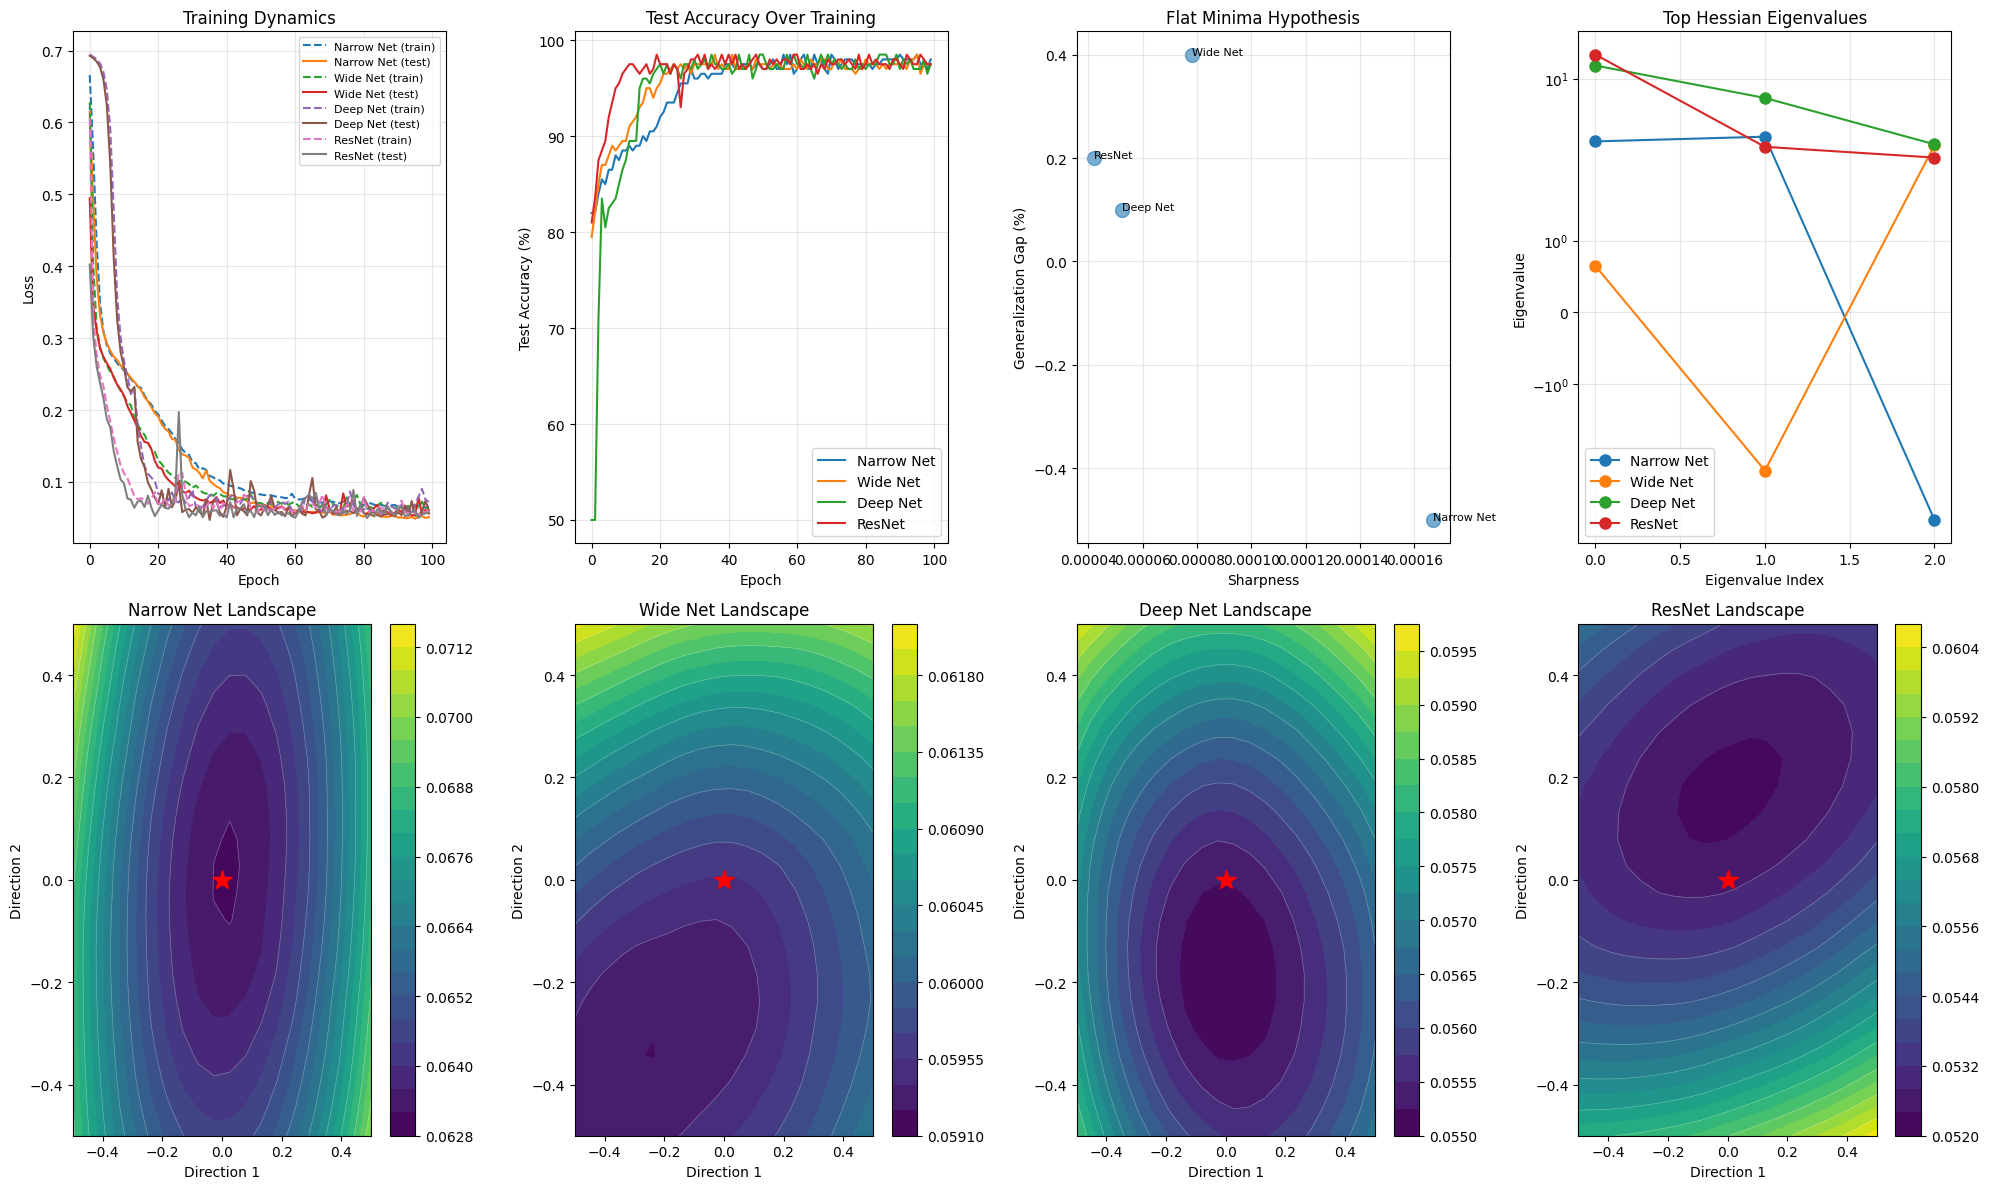

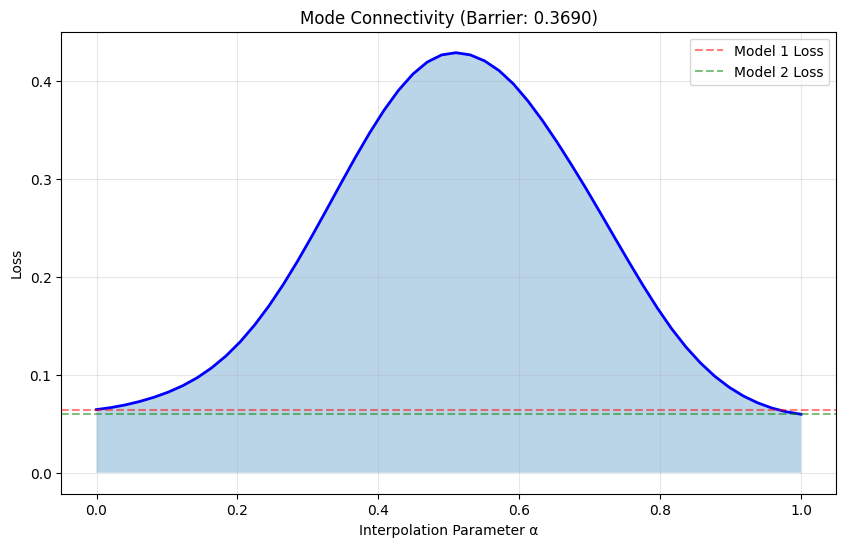

In [10]:
if __name__ == "__main__":
    run_comprehensive_analysis()